In [154]:
%load_ext autoreload
% autoreload 2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='serif')


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#from torch.autograd import Variable
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from geant_dataloader import rtnpy_load_data
from logistics import *
import random
import datetime
from decimal import Decimal
from matplotlib import gridspec

# plotting params
%matplotlib inline
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['figure.figsize'] = (8.0, 8.0)
print(torch.__version__)

from CVAE_plots import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.4.0a0+200fb22


##### CVAE 

Has input of y label at different points 

![CVAE](https://3.bp.blogspot.com/-X-2BF2ZJzlE/WVDBq5YaD_I/AAAAAAAADE0/IXhdDWg8L9oS_fR5kT9iTK8gQOoLullXgCLcBGAs/s1600/conditional_vae.png)

In [452]:
#currently working on 32 x32 implementation


torch.manual_seed(423312)
imageSize = 32
batchSize = 32
manualSeed = None
ngpu = 1
mydir=None # will be updated before the run
norm_scale = 'none'
epoch=0 #will be updated during the run
num_epochs = 100
nc =1
ndf = 64
ngf = 64
beta = 1.0
energy = "100and800and1800MeV"
energies_list, _ = normalize(np.array([800,100,1800]),norm_scale='1to10')
MeV800_test = np.full(5000, energies_list[0])
MeV100_test = np.full(5000, energies_list[1])
MeV1800_test = np.full(5000, energies_list[2])
conditions_lists= [MeV100_test, MeV800_test, MeV1800_test]
unnormalize_loss = False

if imageSize == 64:
    zdim = 128
else:
    zdim = 128
log_interval = 250

mydir=None # will be updated before the run
epoch=0 #will be updated during the run
extraD = 1
epochs = []
genx_FWHMs = []
genx_means = []
realx_FWHMs = []
realx_means =  []
train_losses = []
test_losses = []
sum_differences = []

In [454]:
if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

cudnn.benchmark = True
dev_type = 'cpu'
if torch.cuda.is_available():
    print("Using Cuda")
    dev_type = 'gpu'
    
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("Using:", dev_type, torch.cuda.current_device())


# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1:
#         m.weight.data.normal_(0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         m.weight.data.normal_(1.0, 0.02)
#         m.bias.data.fill_(0)
        

('Random Seed: ', 4562)
Using Cuda
cuda:0
('Using:', 'gpu', 0L)


In [448]:
#image_array = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/rebinnedGeant4Data_20000Events_64OldSize_32NewSize.npy", num_events = 100, image_size = imageSize)
#image_array1 = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/rebinnedGeant4Data_15000Events_64OldSize_32NewSize.npy", num_events = None, image_size = imageSize)
image_array_800MeV = rtnpy_load_data("numpy_data/geant4Data_30000Events_"+str(imageSize)+"ImageSize_800MeV_ScintiAbsoThickness75_8.npz", num_events = None, image_size = imageSize)
image_array_100MeV = rtnpy_load_data("numpy_data/geant4Data_25000Events_"+str(imageSize)+"ImageSize_100MeV_ScintiAbsoThickness75_8.npz", num_events = None, image_size = imageSize)
image_array_1800MeV = rtnpy_load_data("numpy_data/geant4Data_20000Events_"+str(imageSize)+"ImageSize_1800MeV_ScintiAbsoThickness75_8.npz", num_events = None, image_size = imageSize)



MeV800 = np.full((image_array_800MeV.shape[0]), 800.)
MeV100 = np.full((image_array_100MeV.shape[0]), 100.)
MeV1800 = np.full((image_array_1800MeV.shape[0]), 1800)
MeVs = np.concatenate((MeV800,MeV100, MeV1800),axis=0)
#MeVs = MeVs[...,np.newaxis]
MeVs, scale_MeVs = normalize(MeVs[...,np.newaxis],norm_scale='1to10')
images = np.concatenate((image_array_800MeV, image_array_100MeV, image_array_1800MeV),axis=0)
print images.shape, MeVs.shape
#image_array = [images, MeVs]

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

images, MeVs = unison_shuffled_copies(images,MeVs)
#image_array_100MeV = zip(image_array_100MeV, MeV100)

#print norm_scale
normed_array, scale = normalize(images, norm_scale = norm_scale )

tensor_array_train = torch.stack([torch.Tensor(i) for i in normed_array[:50000]])
tensor_labels_train = torch.stack([torch.Tensor(np.array(i)) for i in MeVs[:50000]])
tensor_data_train = torch.utils.data.TensorDataset(tensor_array_train, tensor_labels_train)

tensor_array_test = torch.stack([torch.Tensor(i) for i in normed_array[50000:]])
tensor_labels_test = torch.stack([torch.Tensor(np.array(i)) for i in MeVs[50000:]])
tensor_data_test = torch.utils.data.TensorDataset(tensor_array_test, tensor_labels_test)

train_loader = torch.utils.data.DataLoader(tensor_data_train, batch_size=batchSize, num_workers=8)
test_loader = torch.utils.data.DataLoader(tensor_data_test, batch_size = batchSize, num_workers = 8)
# for i, (data) in enumerate(train_loader,0):
#     data, energies = data[0].to(device)
#     print data, energies
#     break

#image_array=np.concatenate((image_array1, image_array2),0)

(74790, 1, 32, 32) (74790, 1)


In [455]:
def to_img(x, norm_scale = norm_scale, scale = scale, imageSize=imageSize):
    x = x.cpu().data.numpy()
    #x = 0.5 * (x + 1)
   # print x
   # x = np.clip(x, 0, 1)
    
    # this just drops the channel axis
    x = x.reshape([-1, imageSize, imageSize])

    x = unnormalize(x, scale = scale, norm_scale = norm_scale)
    #print x.max()
    
    return x

def plot_reconstructions(model, save_dir=None, epoch = epoch, latent_dim = zdim, conv=False, simple=False, n=4, imageSize=imageSize, norm_scale = norm_scale, batchSize = batchSize, scale = scale):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    """
    # encode then decode
    data, energies = next(iter(test_loader))
    print data.shape,energies.shape

    
    if imageSize == 64:
        full_dim = 4096
    elif imageSize == 32:
        full_dim = 1024
    
    if not conv:
        data = data.view([-1, full_dim])
        data_energy = torch.cat((data,energies),1)
    true_imgs = data
    decoded_imgs, _, _ = model.forward(data_energy.to(device), energies.to(device))
    true_imgs = to_img(true_imgs, norm_scale = norm_scale,  scale = scale)
    decoded_imgs = to_img(decoded_imgs, norm_scale = norm_scale, scale = scale)
    #print(decoded_imgs.shape)
    
    rowsize = n * 2.5
    columnsize = 4
    fig, axn = plt.subplots(figsize=(rowsize, columnsize))
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.98, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    for i in range(n):
        
        # display original
        ax = plt.subplot(2, n, i + 1)

        if i == 0:
            im = plt.imshow(true_imgs[i], cmap=cmap)
        else: 
            plt.imshow(true_imgs[i], cmap=cmap)

        ax.get_xaxis().set_visible(False)
        ax.set_yticklabels([])
        ax.yaxis.set_ticks_position('none') 
        if i == 0:
            ax.set_ylabel("Real", rotation  = 0, fontsize = 13)
            ax.yaxis.set_label_coords(-.25,0.5)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i], cmap=cmap)
        print(decoded_imgs[i].min(), decoded_imgs[i].max())
        if i == 0:
            ax.set_ylabel("Decoded", rotation  = 0, fontsize = 13)
            ax.yaxis.set_label_coords(-.3,0.5)

        ax.get_xaxis().set_visible(False)
        ax.set_yticklabels([])
        ax.yaxis.set_ticks_position('none') 
        

    plt.tight_layout()

    cbar_ax = fig.add_axes([0.97, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    fig.subplots_adjust(wspace=-0.185, hspace=0.09)
    fig.suptitle(r"VAE Real and Decoded Samples of $e^{-}$ $E_{dep}$, "+ str(latent_dim) + " Latent Dim ", x=0.52, y = 1.02)
          
    if save_dir != None:
        #learning_rate = '%.0E' % Decimal(lr)
      
        filename = "VAE_EdepFor" + str(n) + "Events_" + str(latent_dim) +"latentDim_"+ str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize"
 
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    
    return



def plot_conditional_means(model, conditions_lists, scale = scale, norm_scale = norm_scale, 
                      zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000, save_dir=None):

    data_avg_100, n_events = make_samples(model, avg = True, conditions= conditions_lists[0], scale = scale, norm_scale = norm_scale, 
                                          zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000)
    data_avg_800, n_events = make_samples(model, avg = True, conditions= conditions_lists[1], scale = scale, norm_scale = norm_scale, 
                                      zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000)
    data_avg_1800, n_events = make_samples(model, avg = True, conditions= conditions_lists[2], scale = scale, norm_scale = norm_scale, 
                                      zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000)

    MeV100_mean = data_avg_100[1].mean()
    MeV800_mean = data_avg_800[1].mean()
    MeV1800_mean = data_avg_1800[1].mean()

    MeV100_real = image_array_100MeV.mean()
    MeV800_real = image_array_800MeV.mean()
    MeV1800_real = image_array_1800MeV.mean()

    fig = plt.figure(figsize=(5.7,5.7))
    plt.scatter(MeV100_mean, 100, marker='P', s=85, alpha = 0.75, color = 'red', label = '100 MeV')
    plt.scatter(MeV100_real, 100, marker = 's', s = 100, alpha = 0.5, color = 'black')

    plt.scatter(MeV800_mean, 800, marker='P', s=85, alpha = 0.75, color = 'green', label = '800 MeV')
    plt.scatter(MeV800_real, 800, marker = 's', s = 100, alpha = 0.5, color = 'black')

    plt.scatter(MeV1800_mean, 1800, marker='P', s=85, alpha = 0.75, color= u'#ff7f0e', label = '1800 MeV')
    plt.scatter(MeV1800_real, 1800, marker = 's', s = 100, alpha = 0.5, color = 'black',  label = 'real')

    plt.ylim(-200,2000)
    plt.xlim(-.05, 0.40)
    plt.title(r"CVAE Mean $E_{dep}$ Conditioned on Gun Energy", fontsize = 13.5)
    plt.xlabel(r"Mean $\mathit{E_{dep}} \; \, (MeV) $", fontsize=12, fontweight='light', alpha = 0.7)
    plt.ylabel(r"Gun Energy $(MeV)$", fontsize=12, fontweight='light', alpha = 0.7)
    plt.xticks(np.arange(0, MeV1800_real + 0.1, step=0.1))
    plt.legend(loc='best', bbox_to_anchor=(1., 0.25), fontsize=10)
    sns.despine(left=False)
    
    if save_dir != None:
            #directory = "/home/chris/Documents/MPhilProjects/ForViewing/Geant4/SingleLayerEGun/AverageImage/"
            filename = "CVAE_MeanEdepComp" + str(n_events) + "Events_Epochs" + str(epoch) +" .png" 
            plt.savefig(save_dir + filename)
    
    plt.show()
    
    return

In [456]:
if imageSize == 64:
    full_dim = 4096
    leakiness = 0.01
elif imageSize == 32:
    full_dim = 1024
    leakiness = 0.01
    
cond_dim = 1
    
if norm_scale == 'sigmoid' or norm_scale == 'unif':
    #last_decode_act = nn.LeakyReLU(0.01)
    last_decode_act = F.leaky_relu
    #last_decode_act = F.sigmoid
elif norm_scale == '-1to1' or norm_scale == 'tanh':
    last_decode_act = F.tanh
elif norm_scale == 'none' or norm_scale == '1to10':
    last_decode_act = F.leaky_relu

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(full_dim + cond_dim, 650)
        #self.fc12  = nn.Linear(650,400)
        self.fc21 = nn.Linear(650, zdim)
        self.fc22 = nn.Linear(650, zdim)
        self.fc3 = nn.Linear(zdim + cond_dim, 650)
        #self.fc31 = nn.Linear(400, 200)
        self.fc4 = nn.Linear(650, full_dim)

    def encode(self, x):
        h1 = (F.relu(self.fc1(x)))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        #return F.leaky_relu(self.fc4(h3), leakiness)
        #return F.sigmoid(self.fc4(h3))
        if last_decode_act == F.leaky_relu:
            return last_decode_act(self.fc4(h3), leakiness)
        else:
            return last_decode_act(self.fc4(h3))
        #return F.relu(self.fc4(h3))

    def forward(self, x, conds):
        mu, logvar = self.encode(x.view(-1, full_dim + cond_dim))
        z = self.reparameterize(mu, logvar)
        #conditional part
        z_conds = torch.cat((z,conds), 1)
        return self.decode(z_conds), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, beta = beta, full_dim = full_dim, scale= scale, norm_scale =norm_scale, unnormalize_loss = False):
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 1024), size_average=False)
    if unnormalize_loss == True:
        recon_x = unnormalize(recon_x, scale=scale, norm_scale = norm_scale)
        x = unnormalize(x, scale= scale, norm_scale = norm_scale)
    MSE = F.mse_loss(recon_x, x.view(-1,full_dim), size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + beta*KLD


def train(epoch, train_losses):
    model.train()
    train_loss = 0
    for batch_idx, (data_and_conds) in enumerate(train_loader,):
        data = data_and_conds[0].to(device).view([-1, full_dim])
        #print data.shape
        energies = data_and_conds[1].to(device)
        #print energies.shape
        data_energies = torch.cat((data,energies), 1)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data_energies, energies)
        loss = loss_function(recon_batch, data, mu, logvar, beta = beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    avg_batch_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_batch_loss)

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, avg_batch_loss))


def test(epoch, test_losses):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data_and_conds) in enumerate(test_loader,0):
            data = data_and_conds[0].to(device).view([-1, full_dim])
            energies = data_and_conds[1].to(device)
            data_energies = torch.cat((data,energies), 1)
            recon_batch, mu, logvar = model(data_energies, energies)
            test_loss += loss_function(recon_batch, data, mu, logvar, beta = beta).item()
           # if i == 0:
           #     n = min(data.size(0), 8)
               # comparison = torch.cat([data[:n],
                #                      recon_batch.view(batchSize, 1, imageSize, imageSize)[:n]])
                #save_image(comparison.cpu(),
                #         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('====> Test set loss: {:.4f}'.format(test_loss))

print(model)


VAE(
  (fc1): Linear(in_features=1025, out_features=650, bias=True)
  (fc21): Linear(in_features=650, out_features=128, bias=True)
  (fc22): Linear(in_features=650, out_features=128, bias=True)
  (fc3): Linear(in_features=129, out_features=650, bias=True)
  (fc4): Linear(in_features=650, out_features=1024, bias=True)
)


In [ ]:
mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/CVAE/', 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
#mydir = None
if mydir != None:
    try:
        os.makedirs(mydir)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

    with open(mydir + 'NetworkInfo.txt', 'w') as f:
        print >> f, 'model:', model
        print >> f, 'normalization scale:', norm_scale
        print >> f, 'latent dimensionality:', zdim
        print >> f, 'image height/width:', imageSize
        print >> f, 'loss function: MSE + KL div'
        print >> f, 'batch size:', batchSize
        print >> f, 'epochs:', num_epochs
        print >> f, 'beta:', beta
        print >> f, 'gun Energy:', energy
        print >> f, 'last activation layer:', last_decode_act
        print >> f, 'batch size:', batchSize
        print >> f, 'unnormalize loss:', unnormalize_loss


#num_epochs = 250
for epoch in range(1, num_epochs + 1):
    data_avg, n_events = make_samples(model, avg = True, conditions= MeVs, scale = scale, norm_scale = norm_scale, 
                                      zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000)
    data, n_events = make_samples(model, avg = False, conditions= MeVs, scale= scale, norm_scale = norm_scale, 
                                  zdim = zdim, device = device, imageSize=imageSize, normed_array=normed_array, n_events = 5000)
    genx_FWHM = hist_width(np.sum(data_avg[1],1))
    realx_FWHM = hist_width(np.sum(data_avg[0],1))
    genx_mean = np.sum(data_avg[1],1).mean()
    #print genx_mean
    realx_mean = np.sum(data_avg[0],1).mean()
    sum_difference = calc_sum_difference(data_avg)
    sum_differences.append(sum_difference)
    genx_FWHMs.append(genx_FWHM)
    realx_FWHMs.append(realx_FWHM)
    genx_means.append(genx_mean)
    realx_means.append(realx_mean)
    epochs.append(epoch)
    if epoch % 4 == 1:
        plot_reconstructions(model, save_dir=mydir, conv=False, simple=False, n=5, epoch = epoch)
        plot_avg_both(data_avg[0],data_avg[1], n_events, epoch = epoch, imageSize=imageSize, save_dir = mydir)
        plot_difference(data_avg, epoch = epoch, save_dir=mydir, imageSize=imageSize, n_events = n_events)
        samples(source=model, epoch = epoch, conds = MeVs, zdim = zdim, beta=beta, norm_scale = norm_scale, scale = scale, imageSize=imageSize, last_decode_act = last_decode_act, device=device, save_dir = mydir)
    if epoch % 10 == 1:
        plot_all_metrics(genx_FWHMs, realx_FWHMs, genx_means, realx_means,epochs = epochs, n_epochs=num_epochs, save_dir = mydir)
        plot_sum_difference(sum_differences, epochs=epochs, n_epochs=num_epochs, save_dir = mydir)
    train(epoch, train_losses)
    test(epoch, test_losses)
    if epoch % 10 == 1:
        plot_losses(train_losses, test_losses, epochs = epochs, n_epochs=num_epochs, save_dir = mydir)

        plot_conditional_means(model, conditions_lists, save_dir=mydir)
    if epoch == num_epochs:
        samples(source=model,  epoch = epoch, conds = MeVs, zdim=zdim, beta = beta, norm_scale=norm_scale, scale = scale, imageSize = imageSize, device=device, last_decode_act= last_decode_act, rows=1,columns=1, save_dir=mydir)
        
    

In [ ]:


#del epochs[270], train_losses[270], test_losses[270], genx_FWHMs[270], realx_FWHMs[270], genx_means[270], realx_means[270]
#plot_losses(train_losses, test_losses, epochs = epochs, n_epochs=num_epochs, save_dir = mydir)

In [ ]:
MakeGif = True
gif_filename =  mydir + 'VAE_EGun_Erecon_GIF_'  + str(batchSize) + "BatchSize_" + str(num_epochs) + "Epochs_" + str(zdim) +"LatentDim.gif"
        
import imageio
if MakeGif == True:
    png_dir = mydir
    images = []
    file_paths = []
    for subdir, dirs, files in os.walk(png_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            #if file_path.endswith(".png"):
            if "EdepFor5Events" in file_path:
                file_paths.append(file_path)
    #print file_paths
    #file_paths.sort(key=float) 
    file_paths.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
    for i in range(len(file_paths)):      
        images.append(imageio.imread(file_paths[i]))

    imageio.mimsave(gif_filename, images)


In [ ]:
plot_reconstructions(model, save_dir=None, conv=False, simple=False, n=7, epoch = epoch)

In [ ]:
mydir = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/VAE/2018-06-06_20-02-59/"
from matplotlib import gridspec
data_avg, n_events = make_samples(model, avg = True, n_events = 5000)
data, n_events = make_samples(model, avg = False, n_events = 5000)

plot_avg_both(data_avg[0],data_avg[1], n_events, save_dir = mydir,  epoch = epoch)
plot_difference(data_avg, epoch = epoch, save_dir=mydir, norm_scale = norm_scale, n_events = n_events)
samples(model, epoch = epoch, save_dir = mydir)
print mydir

In [ ]:
#THIS IS JUST A DIFFERENT WAY OF PLOTTING WHAT IS BELOW, BELOW IS MORE TIGHT LAYOUT

def new_samples1(model, epoch=epoch, imageSize=imageSize, norm_scale = norm_scale, scale = scale):
    sample = torch.randn(64, zdim).to(device)
    sample = model.decode(sample).cpu()
    sample_new = sample.view(64, 1, imageSize, imageSize).detach().numpy().squeeze()
    data = unnormalize(sample_new, scale = scale, norm_scale = norm_scale)


    columns = 3
    rows = 3
    etaran = (-50,50)
    phiran = (-50,50)
    extent = phiran + etaran
    print data.shape
    fig, axes =plt.subplots(rows,columns, figsize=(6, 6), sharex=True,sharey=True)

    event_number = 0
    plt.locator_params(axis='y', nbins=1)
    plt.locator_params(axis='x', nbins=2)
    #fig.xticks(rotation=45)
    for i in range(rows):
        for j in range(columns):

            image_array = data[event_number ]

            image_array[image_array <= 0] = np.nan
            #cmap = sns.cubehelix_palette(dark = 0.4, light=0.95, gamma = 2.5, hue = 1, start =0, as_cmap=True)
            cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
            #cmap = sns.dark_palette('muted purple', as_cmap=True, input='xkcd')
            #cmap = sns.color_palette("BrBG",7)
            #img = ax.imshow(image_array[0], vmin = 0, extent=extent, origin='lower', cmap=cmap)

            plt.axis('on')
            im =axes[i,j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
            #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
            axes[i,j].set_xticklabels([])
            axes[i,j].set_yticklabels([])
            axes[i,j].xaxis.set_ticks_position('none')
            axes[i,j].yaxis.set_ticks_position('none')
            event_number +=1
    #fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.66])

    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
    #plt.tight_layout()
    fig.subplots_adjust(wspace=0.00, hspace=0)
    fig.suptitle("Samples of Geant4 Electron Gun Energy Depositions", y=0.95)
    plt.show()
    
    return

new_samples1(model, epoch = epoch)

In [ ]:
first_dim = np.linspace(-3.,3.,10)
first_dim = first_dim[...,np.newaxis]
second_dim = np.linspace(-3.,3.,10)
second_dim = second_dim[...,np.newaxis]
first_two = np.concatenate((first_dim,second_dim),1)
rest_noise = np.ones((10,zdim - 2))
latent2d_exploration = torch.FloatTensor(np.concatenate((first_two,rest_noise),1)).to(device)
sample = model.decode(latent2d_exploration).cpu()
data = sample.view(10, 1, imageSize, imageSize).detach().numpy().squeeze()
data.shape

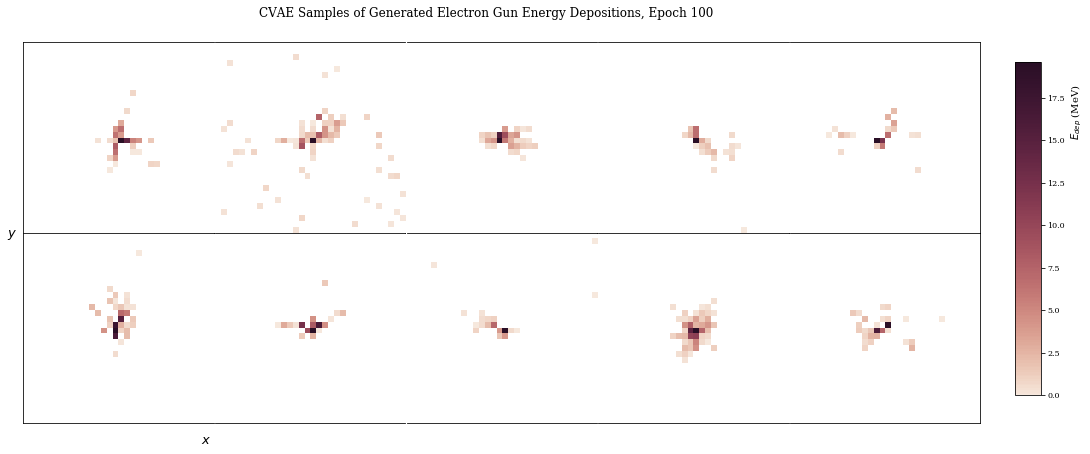

In [460]:
energies_list, _ = normalize(np.array([800,100,1800]),norm_scale='-1to1')
MeV800_test = np.full(5000, energies_list[0])
MeV100_test = np.full(5000, energies_list[1])
MeV1800_test = np.full(5000, energies_list[2])
#data_100 = make_samples(model, avg=True, n_events = 500, conditions=MeV100_test)
#data_100 = make_samplesmake_samples(model, avg=False, conditions, scale, norm_scale, zdim, device, imageSize, normed_array, n_events=500, real=True, fake = True)
#samples(model, epoch = epoch, conds = MeV2000_test, save_dir = mydir)
samples(model, epoch = epoch, conds = MeV1800_test, zdim=zdim,  beta=beta, norm_scale =norm_scale, 
        scale=scale, imageSize=imageSize, last_decode_act=last_decode_act, device=device, save_dir=None, rows=2, columns=5)

In [283]:
data_avg, n_events = make_samples(model, avg = False, conditions= MeV1800_test, scale = scale, norm_scale = norm_scale, 
                                      zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000)

In [284]:
print data_avg[1].mean()
print image_array_1800MeV.mean()

0.18005897
0.3179573136115865


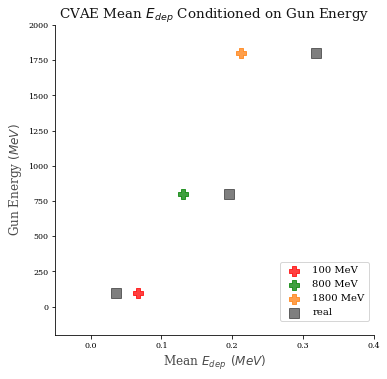

In [438]:
def plot_conditional_means(model, conditions_lists, scale = scale, norm_scale = norm_scale, 
                      zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000):

    data_avg_100, n_events = make_samples(model, avg = True, conditions= conditions_lists[0], scale = scale, norm_scale = norm_scale, 
                                          zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000)
    data_avg_800, n_events = make_samples(model, avg = True, conditions= conditions_lists[1], scale = scale, norm_scale = norm_scale, 
                                      zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000)
    data_avg_1800, n_events = make_samples(model, avg = True, conditions= conditions_lists[2], scale = scale, norm_scale = norm_scale, 
                                      zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000)

    MeV100_mean = data_avg_100[1].mean()
    MeV800_mean = data_avg_800[1].mean()
    MeV1800_mean = data_avg_1800[1].mean()

    MeV100_real = image_array_100MeV.mean()
    MeV800_real = image_array_800MeV.mean()
    MeV1800_real = image_array_1800MeV.mean()

    fig = plt.figure(figsize=(5.7,5.7))
    plt.scatter(MeV100_mean, 100, marker='P', s=85, alpha = 0.75, color = 'red', label = '100 MeV')
    plt.scatter(MeV100_real, 100, marker = 's', s = 100, alpha = 0.5, color = 'black')

    plt.scatter(MeV800_mean, 800, marker='P', s=85, alpha = 0.75, color = 'green', label = '800 MeV')
    plt.scatter(MeV800_real, 800, marker = 's', s = 100, alpha = 0.5, color = 'black')

    plt.scatter(MeV1800_mean, 1800, marker='P', s=85, alpha = 0.75, color= u'#ff7f0e', label = '1800 MeV')
    plt.scatter(MeV1800_real, 1800, marker = 's', s = 100, alpha = 0.5, color = 'black',  label = 'real')

    plt.ylim(-200,2000)
    plt.xlim(-.05, 0.40)
    plt.title(r"CVAE Mean $E_{dep}$ Conditioned on Gun Energy", fontsize = 13.5, alpha=0.92)
    plt.xlabel(r"Mean $\mathit{E_{dep}} \; \, (MeV) $", fontsize=12, fontweight='light', alpha = 0.7)
    plt.ylabel(r"Gun Energy $(MeV)$", fontsize=12, fontweight='light', alpha = 0.7)
    plt.xticks(np.arange(0, MeV1800_real + 0.1, step=0.1))
    plt.legend(loc='best', bbox_to_anchor=(1., 0.25), fontsize=10)
    sns.despine(left=False)
    
    plt.show()
    
    return
    
conditions_lists= [MeV100_test, MeV800_test, MeV1800_test]

plot_conditional_means(model, conditions_lists)
